<a href="https://colab.research.google.com/github/94jjiisu/Data-analysis/blob/master/bean_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 데이터 세트

##- 콩 분류 문제

##-	해당 데이터 세트는 서로 다른 7개 종의 콩 이미지를 고해상도 카메라로 촬영한 13611개의 이미지로 이루어져 있다.

## 데이터의 컬럼은 12개의 특성과 4개의 외형 정보를 포함하고 있다. 컴퓨터 비전 기술과 농업, 데이터분석이 접목된 주제로 주어진 콩의 이미지를 바탕으로 7개의 종류를 구별해내는 모델을 만드는 것이 최종 목적이다.

---


- Features Explanation

1.) Area (A): The area of a bean zone and the number of pixels within its boundaries.

2.) Perimeter (P): Bean circumference is defined as the length of its border.

3.) Major axis length (L): The distance between the ends of the longest line that can be drawn from a bean.

4.) Minor axis length (l): The longest line that can be drawn from the bean while standing perpendicular to the main axis.

5.) Aspect ratio (K): Defines the relationship between L and l.

6.) Eccentricity (Ec): Eccentricity of the ellipse having the same moments as the region.

7.) Convex area (C): Number of pixels in the smallest convex polygon that can contain the area of a bean seed.

8.) Equivalent diameter (Ed): The diameter of a circle having the same area as a bean seed area.

9.) Extent (Ex): The ratio of the pixels in the bounding box to the bean area.

10.)Solidity (S): Also known as convexity. The ratio of the pixels in the convex shell to those found in beans.

11.)Roundness (R): Calculated with the following formula: (4piA)/(P^2)

12.)Compactness (CO): Measures the roundness of an object: Ed/L

13.)ShapeFactor1 (SF1)

14.)ShapeFactor2 (SF2)

15.)ShapeFactor3 (SF3)

16.)ShapeFactor4 (SF4)

17.)Class (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz and Sira)


# 2. 데이터 선정 이유

## - 주제를 정하고 그에 맞는 데이터를 직접 수집, 분석에 투입할 수 있도록 가공하는 작업은 경험상 많이 해 보았지만 오히려 데이터를 다양한 머신러닝 모델을 적용하여 성능을 비교하거나 하이퍼파라미터 튜닝을 해 본 경험이 적어 비교적 데이터 자체는 이미 정리가 끝난 데이터 세트를 준비하였다.

# 3. 문제의 유형

## -	다중클래스 분류(7종 분류), 타겟 클래스는 unbalanced

# 4. 타겟의 설정
## - ‘Class’ 특성을 타겟으로 하여 이를 예측하는 것이 목표

#5. 베이스라인 모델과 평가지표

## -	불균형 다중클래스분류 문제이므로, 의사결정나무 기본 모델을 베이스라인 모델로 하며, 평가 지표는 accuracy와 weighted f1 score를 같이 본다.

# 6. 데이터 정규화
## - Robust Scaler 사용

-----------

# 7. 전처리 과정
# 필요 라이브러리 설치

In [91]:
# !pip install -U pandas-profiling
# !pip install eli5
# !pip install pdpbox
# !pip install shap

In [92]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144
%matplotlib inline
from pandas_profiling import ProfileReport


from sklearn.model_selection import train_test_split, validation_curve, RandomizedSearchCV, GridSearchCV
from scipy.stats import randint, uniform

import graphviz

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, LabelEncoder

from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report, f1_score, roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier


from sklearn.decomposition import PCA

import eli5
from eli5.sklearn import PermutationImportance
import warnings
warnings.filterwarnings('ignore')

warnings.simplefilter(action='ignore', category=FutureWarning)

------------
# 데이터 탑재

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
filename = "/content/drive/MyDrive/DS_camp/session2/Dry_Bean_Dataset.xlsx"

df = pd.read_excel(filename)

In [95]:
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [96]:
df.isna().sum().sort_values()

Area               0
ShapeFactor3       0
ShapeFactor2       0
ShapeFactor1       0
Compactness        0
roundness          0
Solidity           0
ShapeFactor4       0
Extent             0
ConvexArea         0
Eccentricity       0
AspectRation       0
MinorAxisLength    0
MajorAxisLength    0
Perimeter          0
EquivDiameter      0
Class              0
dtype: int64

# 중복 데이터 확인 및 삭제

In [97]:
df.duplicated().sum()

68

In [98]:
df.drop_duplicates(keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)

# 클래스 분포 및 비율 파악 -> 불균형

In [99]:
df.Class.value_counts()

DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1860
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: Class, dtype: int64

In [100]:
class_names = ['BARBUNYA',	'BOMBAY',	'CALI',	'DERMASON',	'HOROZ',	'SEKER',	'SIRA']

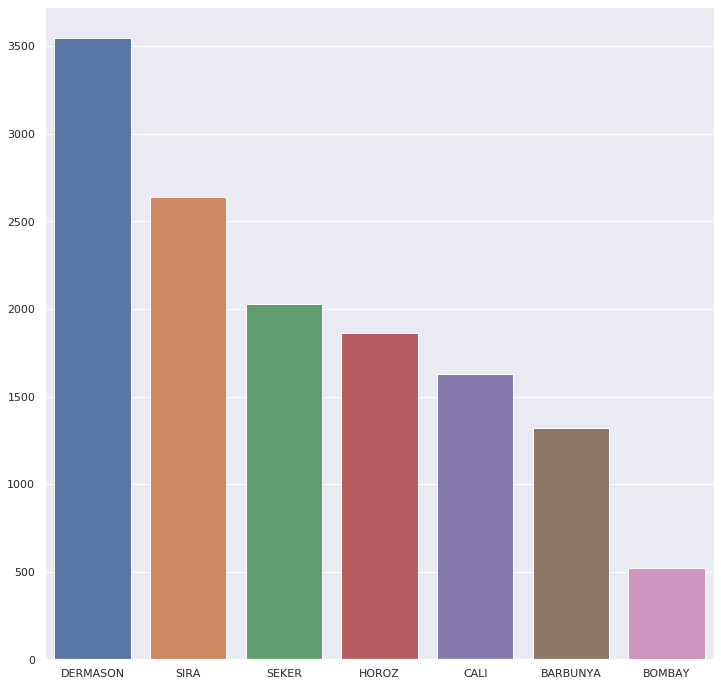

In [101]:
cnt = df.Class.value_counts()
plt.figure(figsize=(12,12))
sns.barplot(x = cnt.index, y = cnt.values);

In [102]:
df.head(3)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER


# 특성들의 분포 확인

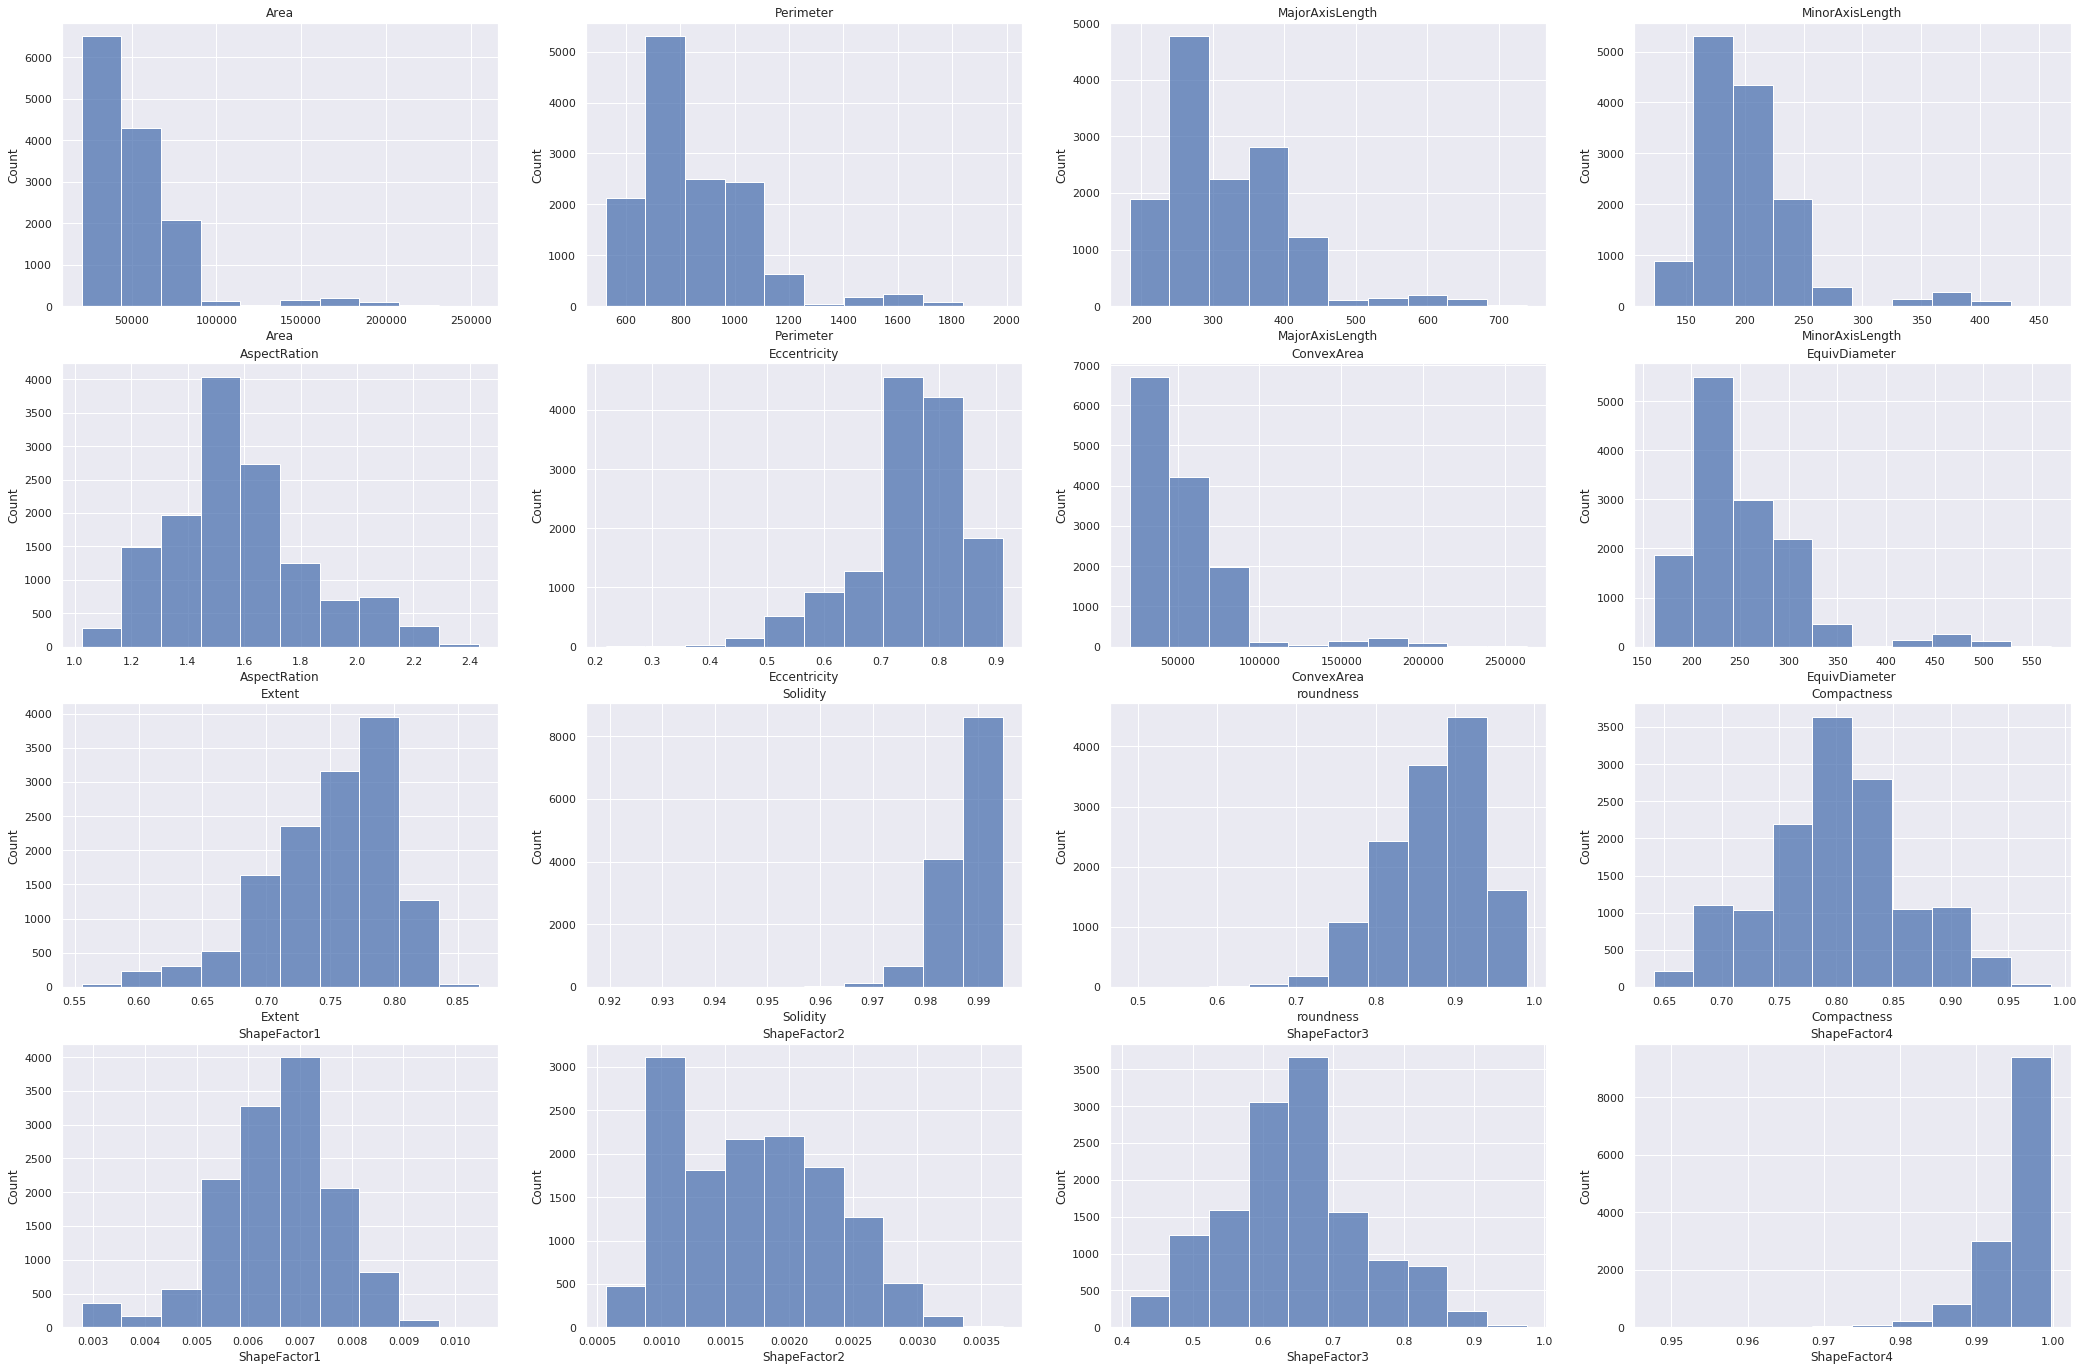

In [103]:
COLUMNS = df.columns.tolist()

feature_cols = COLUMNS[:-1]
sns.set(style='darkgrid')
fig, ax_list = plt.subplots(nrows=4, ncols=4, sharey=False, figsize=(36,24))
ax_list = ax_list.flatten()
for name, ax in zip(feature_cols, ax_list):
     g = sns.histplot(df, x=name, bins=10, ax=ax).set(title=name)

# 특성들 중 'MajorAxisLength', 'MinorAxisLength' 를 사용하여 산점도를 그림

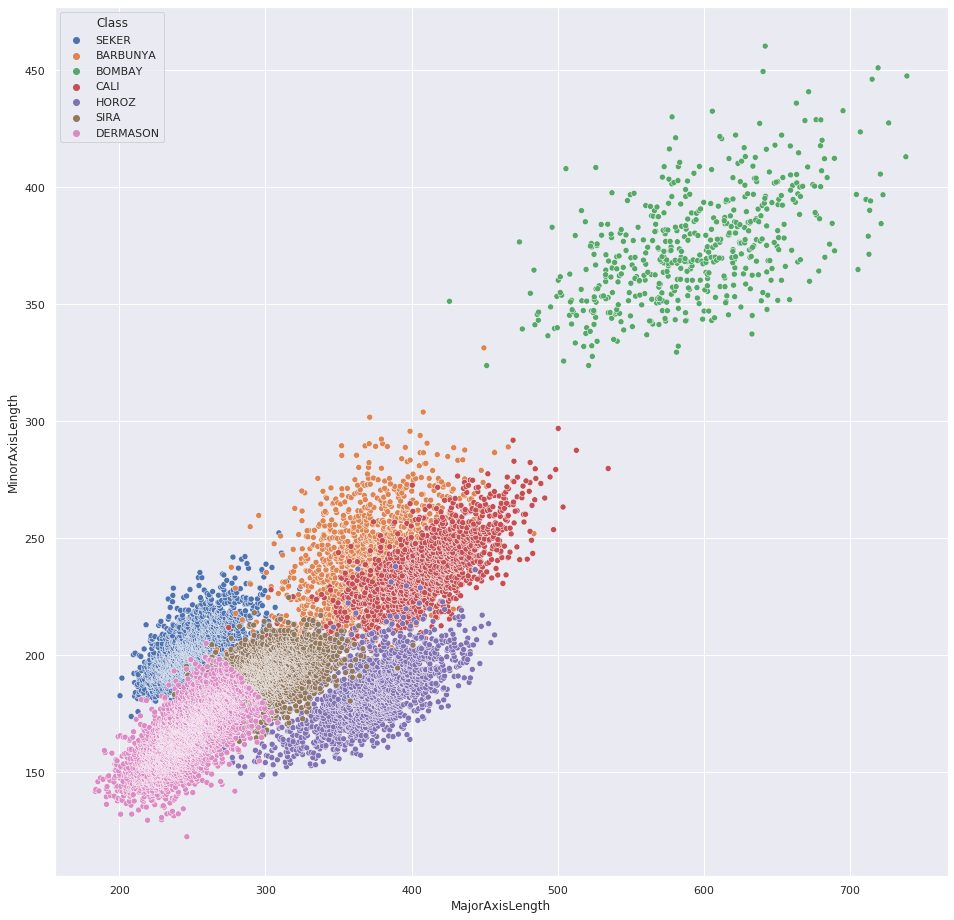

In [104]:
plt.figure(figsize=(16,16))
sns.scatterplot(x=df['MajorAxisLength'], y=df['MinorAxisLength'], hue=df['Class']);

In [105]:
target = 'Class'

label = df[target]
features = df.drop([target], axis=1)

In [106]:
scaler = StandardScaler()
Z = scaler.fit_transform(features)

output = pd.DataFrame(Z, columns=features.columns, index=list(features.index.values))

In [107]:
pca = PCA(2)
df_pca= pca.fit_transform(output)
df_pca = pd.DataFrame(data = df_pca, columns=['PC1', 'PC2'])

In [108]:
df_pca['Class'] = label

# PCA(2) 를 수행하여 주성분 2개로 산점도를 그림

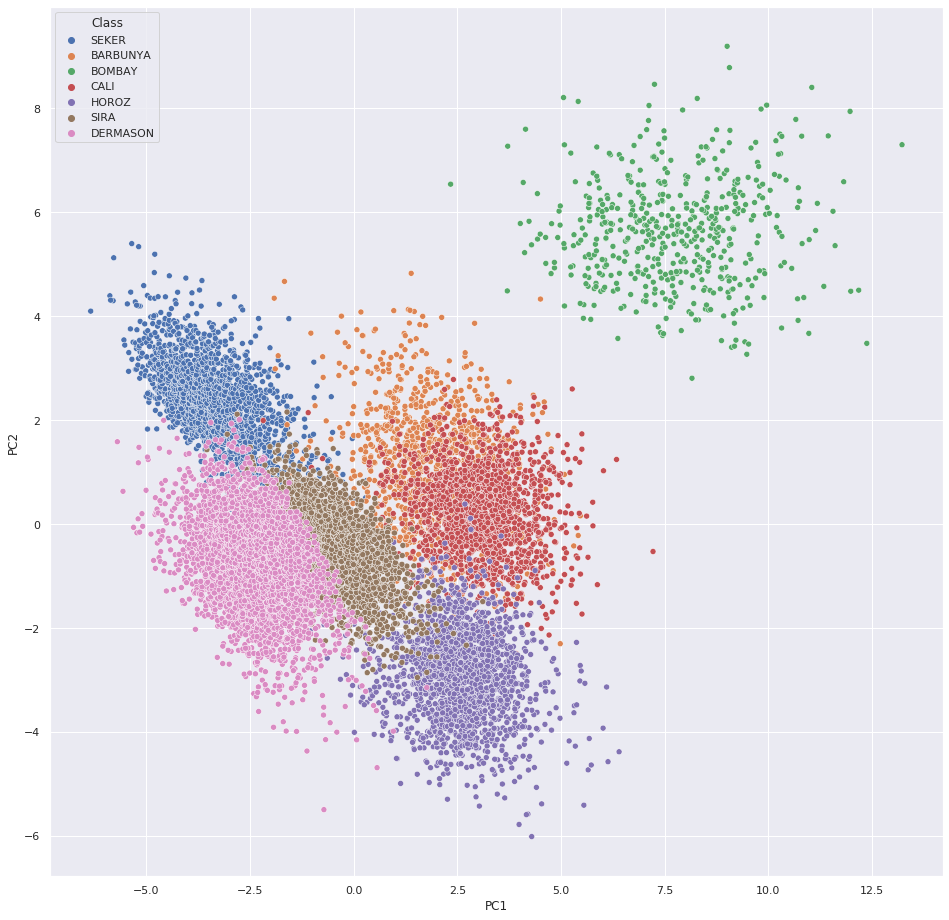

In [109]:
plt.figure(figsize=(16,16))
sns.scatterplot(x = 'PC1', y = 'PC2', data = df_pca, hue = 'Class');

# 'BOMBAY' 클래스는 다른 클래스들에 비해 확연히 구별이 쉽다

In [110]:
area = df['Area'].groupby(df['Class']).mean().sort_values()

# 'BOMBAY' 콩은 다른 콩들에 비해 크기가 크다 (area)

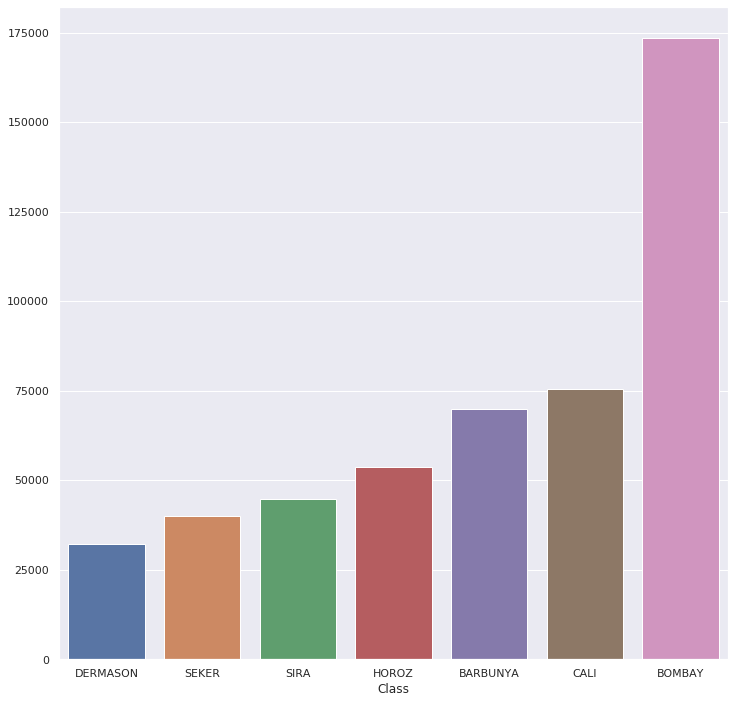

In [111]:
plt.figure(figsize=(12,12))
sns.barplot(x = area.index, y = area.values);

-----------

# 데이터를 훈련, 검증, 테스트 데이터로 나눈다

# 클래스의 분포 비율이 유지되도록 한다

In [112]:
target = 'Class'

train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df[target], random_state=2)

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)

train.shape, val.shape, test.shape

((8667, 17), (2167, 17), (2709, 17))

In [113]:
train[target].value_counts(normalize=True)

DERMASON    0.261913
SIRA        0.194646
SEKER       0.149648
HOROZ       0.137302
CALI        0.120342
BARBUNYA    0.097612
BOMBAY      0.038537
Name: Class, dtype: float64

In [114]:
val[target].value_counts(normalize=True)

DERMASON    0.261652
SIRA        0.194739
SEKER       0.149515
HOROZ       0.137517
CALI        0.120443
BARBUNYA    0.097370
BOMBAY      0.038763
Name: Class, dtype: float64

In [115]:
test[target].value_counts(normalize=True)

DERMASON    0.261720
SIRA        0.194537
SEKER       0.149871
HOROZ       0.137320
CALI        0.120340
BARBUNYA    0.097822
BOMBAY      0.038391
Name: Class, dtype: float64

# 타겟 분리

In [116]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# 8. 베이스라인 모델: 의사결정나무 분류 default model

In [117]:
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

predict = dt_clf.predict(X_val)
f1=f1_score(y_val, predict, average='weighted')
print("검증 세트 정확도", dt_clf.score(X_val, y_val))
print()
print("검증 세트 F1 score: {}" .format(f1))

검증 세트 정확도 0.889247808029534

검증 세트 F1 score: 0.8891375007155944


In [118]:
predict = dt_clf.predict(X_test)
f1=f1_score(y_test, predict, average='weighted')

print('테스트 세트 정확도', dt_clf.score(X_test, y_test))
print()
print("테스트 세트 F1 score: {}" .format(f1))

테스트 세트 정확도 0.8959025470653378

테스트 세트 F1 score: 0.8959994964512971


# 검증 세트보다 테스트 세트의 점수가 더 높게 나오는 것으로 보아 과적합이 심한 데이터 세트는 아닌 듯 하다

In [119]:
confusion = pd.DataFrame({'Class': test['Class'], 'Predict': predict})
# Create crosstab: ct
ct = pd.crosstab(confusion['Class'], confusion['Predict'])
print(classification_report(predict, test['Class']))
print()
ct

              precision    recall  f1-score   support

    BARBUNYA       0.92      0.86      0.89       281
      BOMBAY       0.99      1.00      1.00       103
        CALI       0.90      0.92      0.91       318
    DERMASON       0.88      0.90      0.89       694
       HOROZ       0.92      0.93      0.92       368
       SEKER       0.95      0.94      0.94       411
        SIRA       0.83      0.82      0.83       534

    accuracy                           0.90      2709
   macro avg       0.91      0.91      0.91      2709
weighted avg       0.90      0.90      0.90      2709




Predict,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Class,,,,,,,
BARBUNYA,243,0,14,0,0,4,4
BOMBAY,1,103,0,0,0,0,0
CALI,22,0,293,0,7,1,3
DERMASON,0,0,0,622,5,13,69
HOROZ,5,0,7,3,342,0,15
SEKER,3,0,1,13,0,385,4
SIRA,7,0,3,56,14,8,439


# 눈으로도 구별하기 쉬웠던 BOMBAY 콩은 100%의 f1_score를 보여준다.

# SIRA 콩은 가장 점수가 낮다. 아마도 서로 밀집해 있는 6종의 콩 중에서 가장 가운데에 위치하기 때문인 듯 하다.

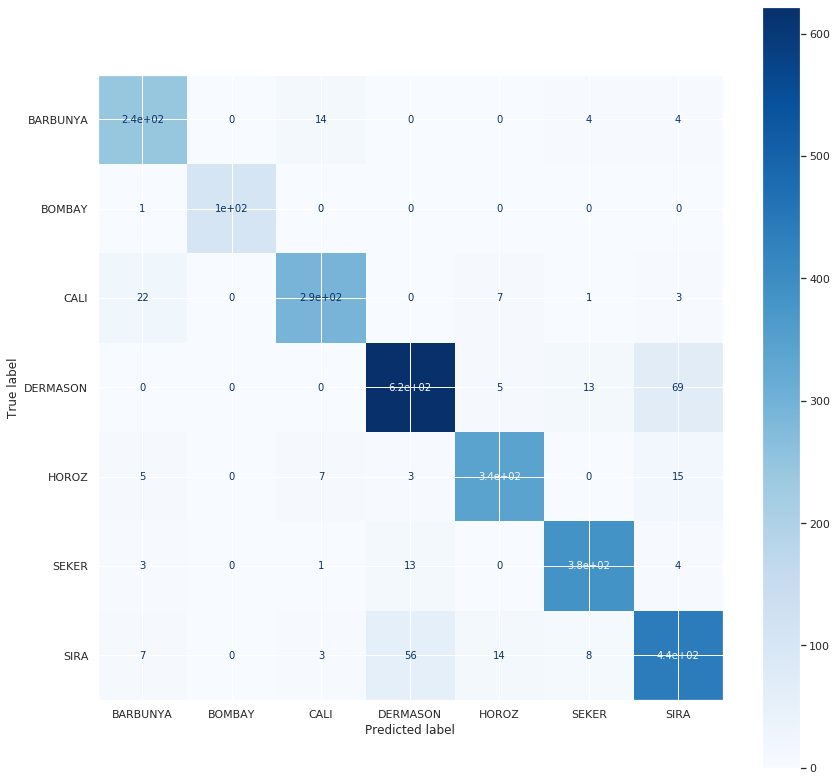

In [120]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(14, 14))
disp = plot_confusion_matrix(dt_clf, X_test, y_test, 
                             display_labels=class_names, cmap=plt.cm.Blues, 
                              ax = ax)

# 베이스라인 모델의 특성 중요도

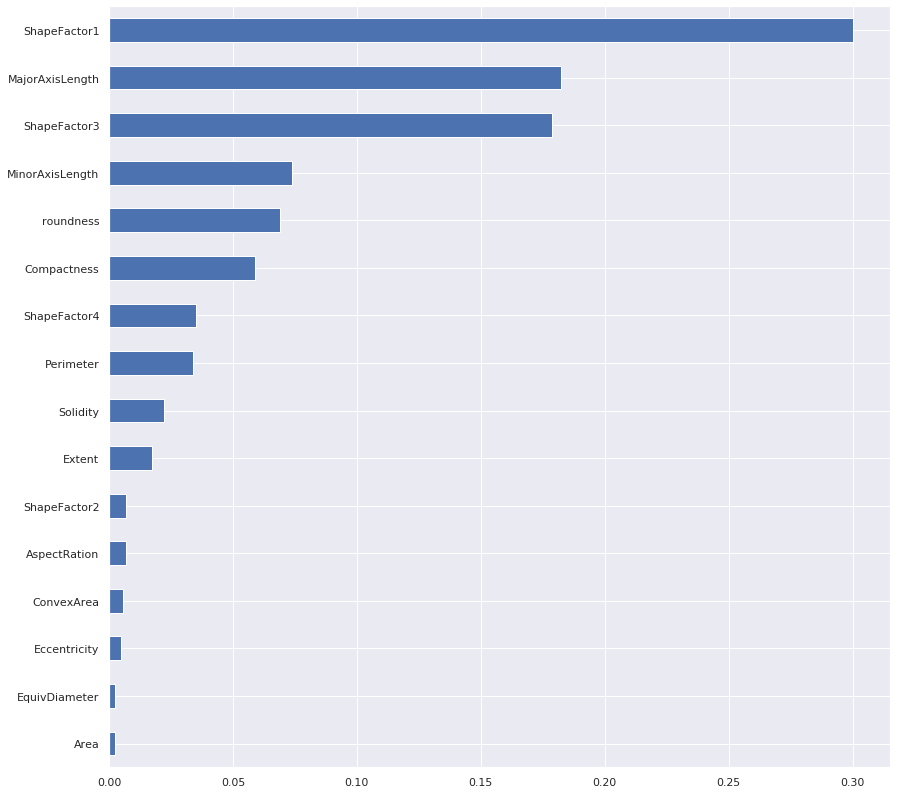

In [121]:
model_dt = dt_clf

importances = pd.Series(model_dt.feature_importances_, X_train.columns)
plt.figure(figsize=(14,14))
importances.sort_values().plot.barh();

# 학습 데이터 세트에서의 'ShapeFactor1' 의 분포

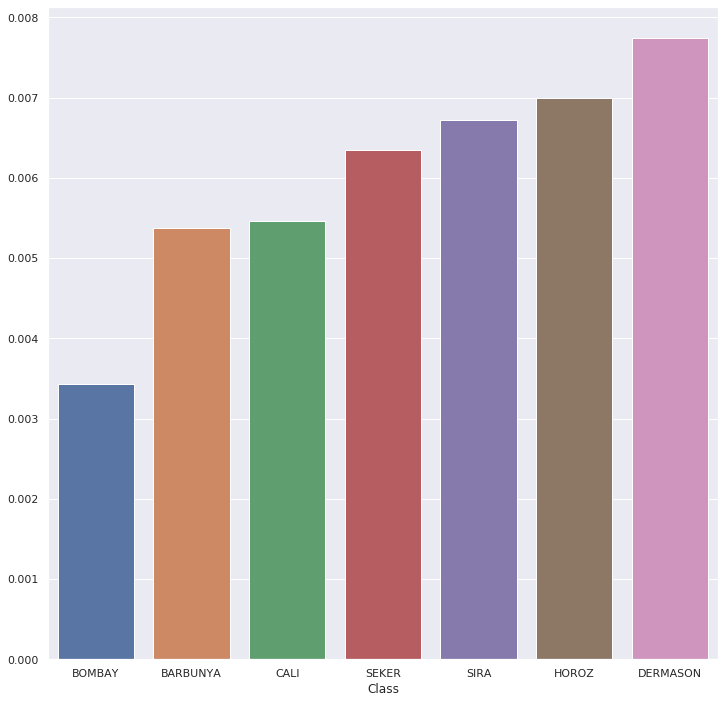

In [122]:
ft1 = train['ShapeFactor1'].groupby(df['Class']).mean().sort_values()
plt.figure(figsize=(12,12))
sns.barplot(x = ft1.index, y = ft1.values);

# 학습 데이터 세트에서의 'ShapeFactor3' 의 분포

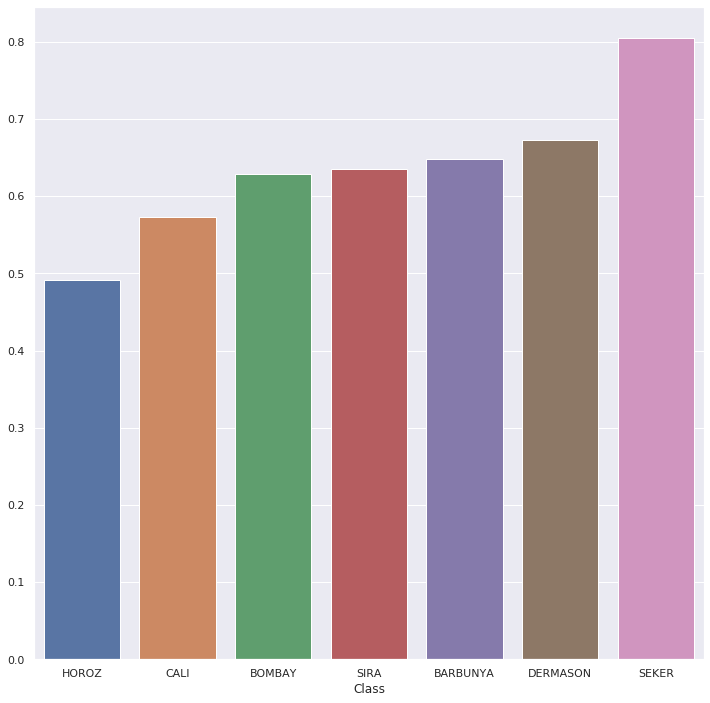

In [123]:
ft3 = train['ShapeFactor3'].groupby(df['Class']).mean().sort_values()
plt.figure(figsize=(12,12))
sns.barplot(x = ft3.index, y = ft3.values);

------------
# 9. 의사결정나무 파이퍼파라미터 튜닝 분류 모델

## 튜닝 과정은 코드 맨 아래에 있으며 코랩이 아닌 파이참으로 진행

In [124]:
pipe_tree = make_pipeline(
    RobustScaler(),
    DecisionTreeClassifier(random_state=42)
)

params = {
    'decisiontreeclassifier__class_weight' : [None],
    'decisiontreeclassifier__max_depth' : [16],
    'decisiontreeclassifier__min_samples_leaf' : [6],
    'decisiontreeclassifier__max_features':[12]
}

clf1 = GridSearchCV(
    pipe_tree,
    param_grid=params,
    cv=5,
    n_jobs=-1
    )

clf1.fit(X_train, y_train)


print('최적 하이퍼파라미터: ', clf1.best_params_)
print()
print('accuracy: ', clf1.best_score_)
print()
m0 = clf1.best_estimator_

m0.fit(X_val, y_val)
print('검증 정확도', m0.score(X_val, y_val))
print()
predict = m0.predict(X_val)
f1=f1_score(y_val, predict, average='weighted')

print("F1 score: {}" .format(f1))
print()

최적 하이퍼파라미터:  {'decisiontreeclassifier__class_weight': None, 'decisiontreeclassifier__max_depth': 16, 'decisiontreeclassifier__max_features': 12, 'decisiontreeclassifier__min_samples_leaf': 6}

accuracy:  0.9050430911986668

검증 정확도 0.9413936317489617

F1 score: 0.9414098873698826



In [125]:
test_pred = m0.predict(X_test)

confusion = pd.DataFrame({'Class': test['Class'], 'Predict': test_pred})
# Create crosstab: ct
ct = pd.crosstab(confusion['Class'], confusion['Predict'])

print(classification_report(test_pred, test['Class']))
print()
ct

              precision    recall  f1-score   support

    BARBUNYA       0.90      0.89      0.90       268
      BOMBAY       0.96      1.00      0.98       100
        CALI       0.89      0.93      0.91       311
    DERMASON       0.91      0.89      0.90       724
       HOROZ       0.95      0.94      0.94       376
       SEKER       0.91      0.95      0.93       389
        SIRA       0.86      0.84      0.85       541

    accuracy                           0.90      2709
   macro avg       0.91      0.92      0.91      2709
weighted avg       0.90      0.90      0.90      2709




Predict,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Class,,,,,,,
BARBUNYA,239,0,11,0,1,6,8
BOMBAY,1,100,3,0,0,0,0
CALI,25,0,290,0,10,0,1
DERMASON,0,0,0,642,1,5,61
HOROZ,2,0,4,4,353,0,9
SEKER,1,0,0,26,0,369,10
SIRA,0,0,3,52,11,9,452


# 베이스라인 모델에 비해 각 콩의 종류별 성능은 조금씩 달라졌으나, 전체적인 정확도나 f1_score는 변함이 없다.

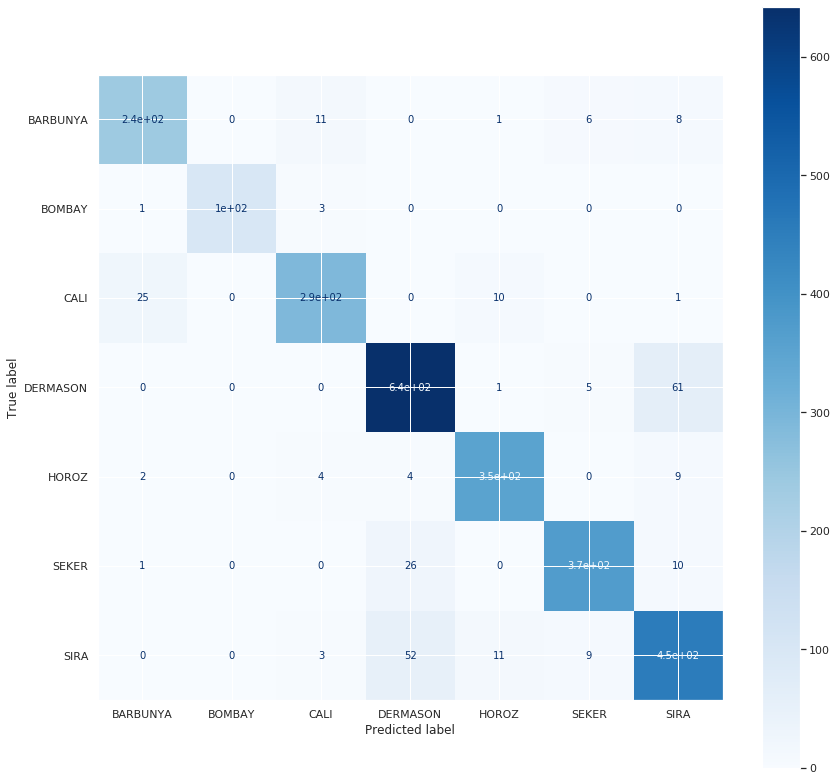

In [126]:
fig, ax = plt.subplots(figsize=(14, 14))
disp = plot_confusion_matrix(m0, X_test, y_test, 
                             display_labels=class_names, cmap=plt.cm.Blues, 
                              ax = ax,
                             )

In [127]:
print('테스트 정확도', m0.score(X_test, y_test))

테스트 정확도 0.902547065337763


# 튜닝 의사결정나무 분류 모델의 특성 중요도

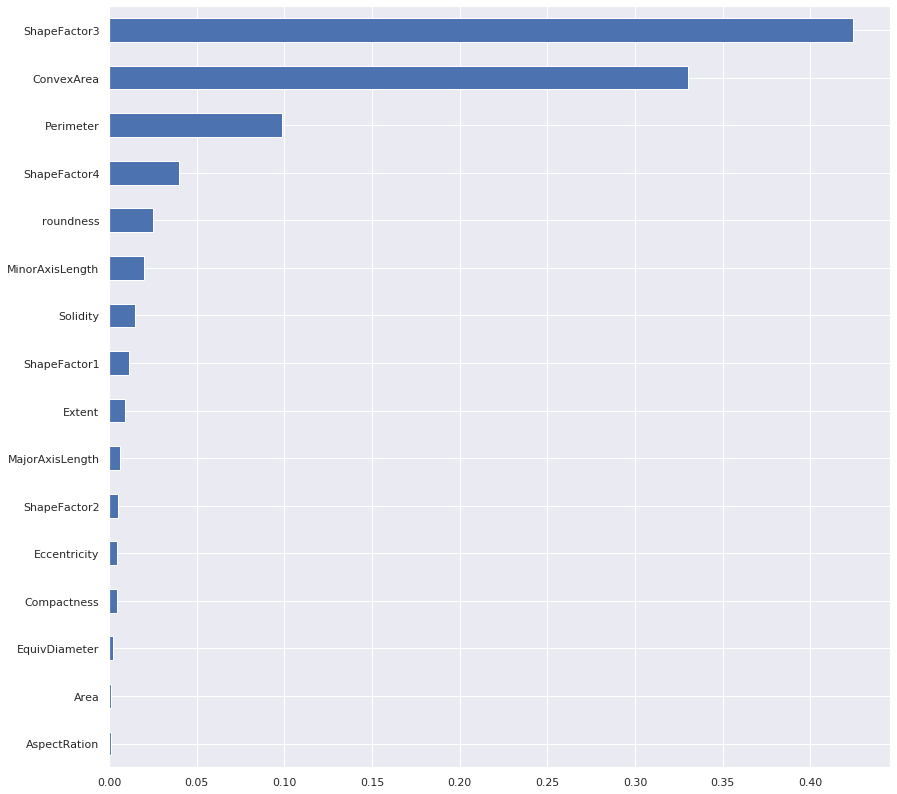

In [128]:
model_dt = m0.named_steps['decisiontreeclassifier']

importances = pd.Series(model_dt.feature_importances_, X_test.columns)
plt.figure(figsize=(14,14))
importances.sort_values().plot.barh();

In [129]:
from sklearn.pipeline import Pipeline

pipe_dt = Pipeline([
    ('preprocessing', RobustScaler()),
    ('dt', DecisionTreeClassifier(random_state=42, class_weight= None, max_depth = 16, 
                                  max_features=12, min_samples_leaf= 6)) 
])

In [130]:
pipe_dt.fit(X_train, y_train)
print('검증 정확도: ', pipe_dt.score(X_val, y_val))

검증 정확도:  0.9081679741578219


In [131]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    pipe_dt.named_steps['dt'],
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

X_val_transformed = pipe_dt.named_steps['preprocessing'].transform(X_val)

permuter.fit(X_val_transformed, y_val);

In [132]:
feature_names = X_val.columns.tolist()

# 튜닝 의사결정나무 분류 모델의 Permutation importance

## 순서대로 

##MajorAxisLength 가 0.2618 ± 0.0137

##ShapeFactor1 가 0.1577 ± 0.0085

##ShapeFactor3 가 0.0975 ± 0.0074

## 만큼 영향을 미쳤다.

In [133]:
eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=feature_names 
)

Weight,Feature
0.2618 ± 0.0137,MajorAxisLength
0.1577 ± 0.0085,ShapeFactor1
0.0975 ± 0.0074,ShapeFactor3
0.0775 ± 0.0094,Perimeter
0.0763 ± 0.0098,ShapeFactor4
0.0755 ± 0.0088,roundness
0.0593 ± 0.0069,Compactness
0.0457 ± 0.0097,MinorAxisLength
0.0146 ± 0.0051,Solidity
0.0126 ± 0.0015,ConvexArea


#10. 랜덤포레스트 분류 모델

In [134]:
pipe_rf = make_pipeline(
    RobustScaler(), 
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

params = {
    'randomforestclassifier__class_weight' : [None],
    'randomforestclassifier__max_depth' : [16],
    'randomforestclassifier__n_estimators' : [550],
    'randomforestclassifier__min_samples_leaf' : [4],
    'randomforestclassifier__max_features' : ['auto']
}

clf1 = GridSearchCV(
    pipe_rf,
    param_grid=params,
    cv=5,
    n_jobs=-1
    )

clf1.fit(X_train, y_train)


print('최적 하이퍼파라미터: ', clf1.best_params_)
print()
print('accuracy: ', clf1.best_score_)
print()
m1 = clf1.best_estimator_

m1.fit(X_val, y_val)
print('검증 정확도', m1.score(X_val, y_val))
print()
predict = m1.predict(X_val)
f1=f1_score(y_val, predict, average='weighted')

print("F1 score: {}" .format(f1))
print()

최적 하이퍼파라미터:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 16, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__n_estimators': 550}

accuracy:  0.9208500969377263

검증 정확도 0.9584679280110752

F1 score: 0.958391035244608



In [135]:
test_pred = m1.predict(X_test)

confusion = pd.DataFrame({'Class': test['Class'], 'Predict': test_pred})
# Create crosstab: ct
ct = pd.crosstab(confusion['Class'], confusion['Predict'])

print(classification_report(test_pred, test['Class']))
print()
ct

              precision    recall  f1-score   support

    BARBUNYA       0.89      0.93      0.91       256
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.92      0.94      0.93       321
    DERMASON       0.91      0.91      0.91       716
       HOROZ       0.94      0.96      0.95       366
       SEKER       0.96      0.96      0.96       407
        SIRA       0.87      0.85      0.86       539

    accuracy                           0.92      2709
   macro avg       0.93      0.93      0.93      2709
weighted avg       0.92      0.92      0.92      2709




Predict,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Class,,,,,,,
BARBUNYA,237,0,14,0,0,2,12
BOMBAY,0,104,0,0,0,0,0
CALI,16,0,301,0,8,0,1
DERMASON,0,0,0,648,0,7,54
HOROZ,1,0,6,5,351,0,9
SEKER,0,0,0,13,0,390,3
SIRA,2,0,0,50,7,8,460


# 앙상블 모델을 사용하니 성능이 전체적으로 향상되었다.

# 90% -> 92%

# BOMBAY 콩을 100% 맞추기 시작한다.

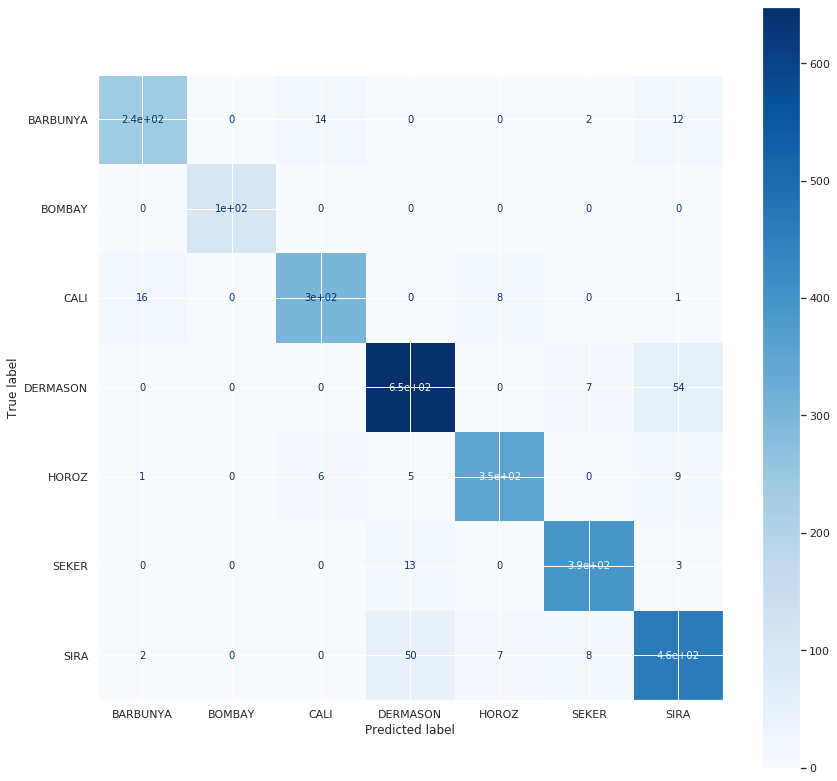

In [136]:
fig, ax = plt.subplots(figsize=(14, 14))
disp = plot_confusion_matrix(m1, X_test, y_test, 
                             display_labels=class_names, cmap=plt.cm.Blues, 
                              ax = ax,
                             )

# 부스팅 모델을 위한 데이터 스케일링

In [137]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(data = X_train_scaled, columns=X_train.columns)

X_val_scaled = scaler.transform(X_val)
X_val_scaled = pd.DataFrame(data = X_val_scaled, columns=X_val.columns)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(data = X_test_scaled, columns=X_test.columns)

# 클래스 불균형 문제를 보완하기 위해 각 클래스마다 가중치를 설정한다.

In [138]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight('balanced', y_train)

# 11. XGBoost 분류 모델

In [139]:
model_xgb = XGBClassifier(
    n_estimators=1000,  
    max_depth=4,        
    learning_rate=0.1,
    scale_pos_weight=classes_weights,
    n_jobs=-1
)

eval_set = [(X_train_scaled, y_train), 
            (X_val_scaled, y_val)]

model_xgb.fit(X_train_scaled, y_train, 
          eval_set=eval_set,
          eval_metric='mlogloss',
          early_stopping_rounds=30
         ) 

[0]	validation_0-mlogloss:1.66736	validation_1-mlogloss:1.6712
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.46469	validation_1-mlogloss:1.4729
[2]	validation_0-mlogloss:1.30606	validation_1-mlogloss:1.31758
[3]	validation_0-mlogloss:1.1767	validation_1-mlogloss:1.19137
[4]	validation_0-mlogloss:1.06781	validation_1-mlogloss:1.08472
[5]	validation_0-mlogloss:0.973716	validation_1-mlogloss:0.992689
[6]	validation_0-mlogloss:0.892102	validation_1-mlogloss:0.913369
[7]	validation_0-mlogloss:0.821739	validation_1-mlogloss:0.844912
[8]	validation_0-mlogloss:0.758768	validation_1-mlogloss:0.78393
[9]	validation_0-mlogloss:0.702706	validation_1-mlogloss:0.730039
[10]	validation_0-mlogloss:0.652866	validation_1-mlogloss:0.682322
[11]	validation_0-mlogloss:0.608444	validation_1-mlogloss:0.639732
[12]	validation_0-mlogloss:0.568318	validation_1-mlog

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1,
              scale_pos_weight=array([1.04045618, 1.04045618, 1.46352584, ..., 1.18709766, 0.73393175,
       0.95462055]),
              seed=None, silent=None, subsample=1, verbosity=1)

# 분류 오차 함수가 초반부터 급격하게 감소하는 형태

# 138 에서 학습 종료

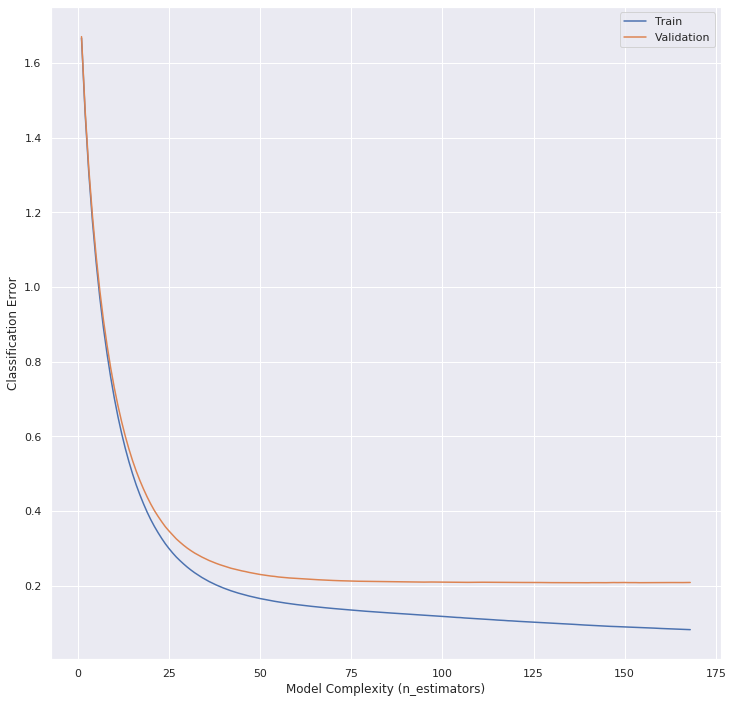

In [140]:
plt.figure(figsize=(12,12))
results = model_xgb.evals_result()
train_error = results['validation_0']['mlogloss']
val_error = results['validation_1']['mlogloss']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
#plt.ylim((0.15, 0.25)) # Zoom in
plt.legend();

# 검증 세트의 성능은 랜덤포레스트 모델보다 약간 떨어진다.

In [141]:
print('검증 정확도', model_xgb.score(X_val_scaled, y_val))
print()
print(classification_report(y_val, model_xgb.predict(X_val_scaled)))

검증 정확도 0.9233964005537609

              precision    recall  f1-score   support

    BARBUNYA       0.93      0.93      0.93       211
      BOMBAY       1.00      1.00      1.00        84
        CALI       0.95      0.95      0.95       261
    DERMASON       0.91      0.92      0.91       567
       HOROZ       0.97      0.95      0.96       298
       SEKER       0.94      0.92      0.93       324
        SIRA       0.86      0.88      0.87       422

    accuracy                           0.92      2167
   macro avg       0.94      0.94      0.94      2167
weighted avg       0.92      0.92      0.92      2167



In [142]:
predict = model_xgb.predict(X_val_scaled)
f1=f1_score(y_val, predict, average='weighted')
print("F1 score: {}" .format(f1))

F1 score: 0.9235965710495074


# 하지만 테스트 세트의 성능은 랜덤포레스트 모델보다 높다

In [143]:
test_pred = model_xgb.predict(X_test_scaled)

confusion = pd.DataFrame({'Class': test['Class'], 'Predict': test_pred})
# Create crosstab: ct
ct = pd.crosstab(confusion['Predict'], confusion['Class'])

print(classification_report(test_pred, test['Class']))
ct

              precision    recall  f1-score   support

    BARBUNYA       0.96      0.95      0.95       267
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.96      0.97      0.96       323
    DERMASON       0.93      0.92      0.92       719
       HOROZ       0.94      0.98      0.96       359
       SEKER       0.96      0.96      0.96       405
        SIRA       0.88      0.88      0.88       532

    accuracy                           0.94      2709
   macro avg       0.95      0.95      0.95      2709
weighted avg       0.93      0.94      0.93      2709



Class,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Predict,,,,,,,
BARBUNYA,254,0,9,0,1,3,0
BOMBAY,0,104,0,0,0,0,0
CALI,6,0,312,0,4,0,1
DERMASON,0,0,0,658,3,9,49
HOROZ,0,0,3,0,351,0,5
SEKER,1,0,0,10,0,388,6
SIRA,4,0,2,41,13,6,466


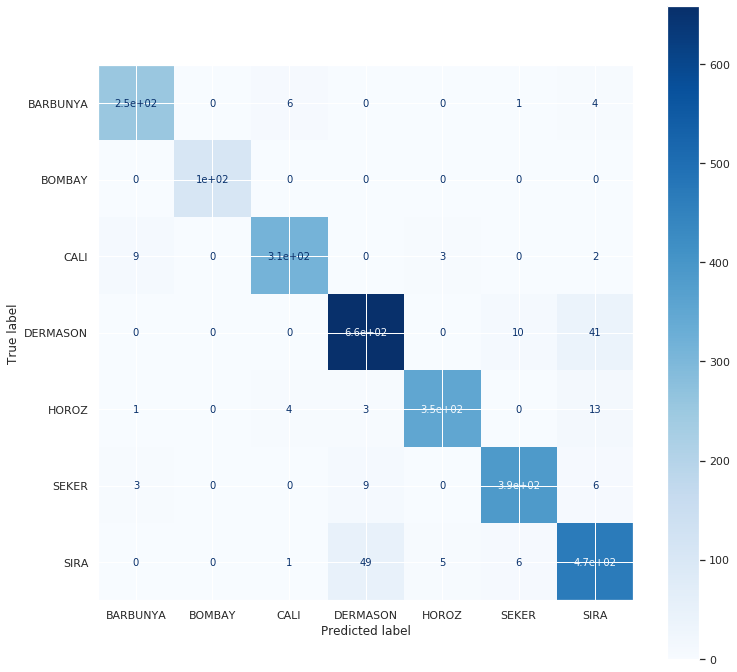

In [144]:
fig, ax = plt.subplots(figsize=(12, 12))
disp = plot_confusion_matrix(model_xgb, X_test_scaled, y_test, 
                             display_labels=class_names, cmap=plt.cm.Blues, 
                              ax = ax,
                             )

In [145]:
plt.rcParams['figure.dpi'] = 144

In [146]:
model_xgb.get_booster().feature_names = X_val_scaled.columns

In [147]:
import shap
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_train_scaled)

In [148]:
class_names = ['BARBUNYA',	'BOMBAY',	'CALI',	'DERMASON',	'HOROZ',	'SEKER',	'SIRA']

# XGBoost 모델의 SHAP summary_plot
# 클래스 전체 평균

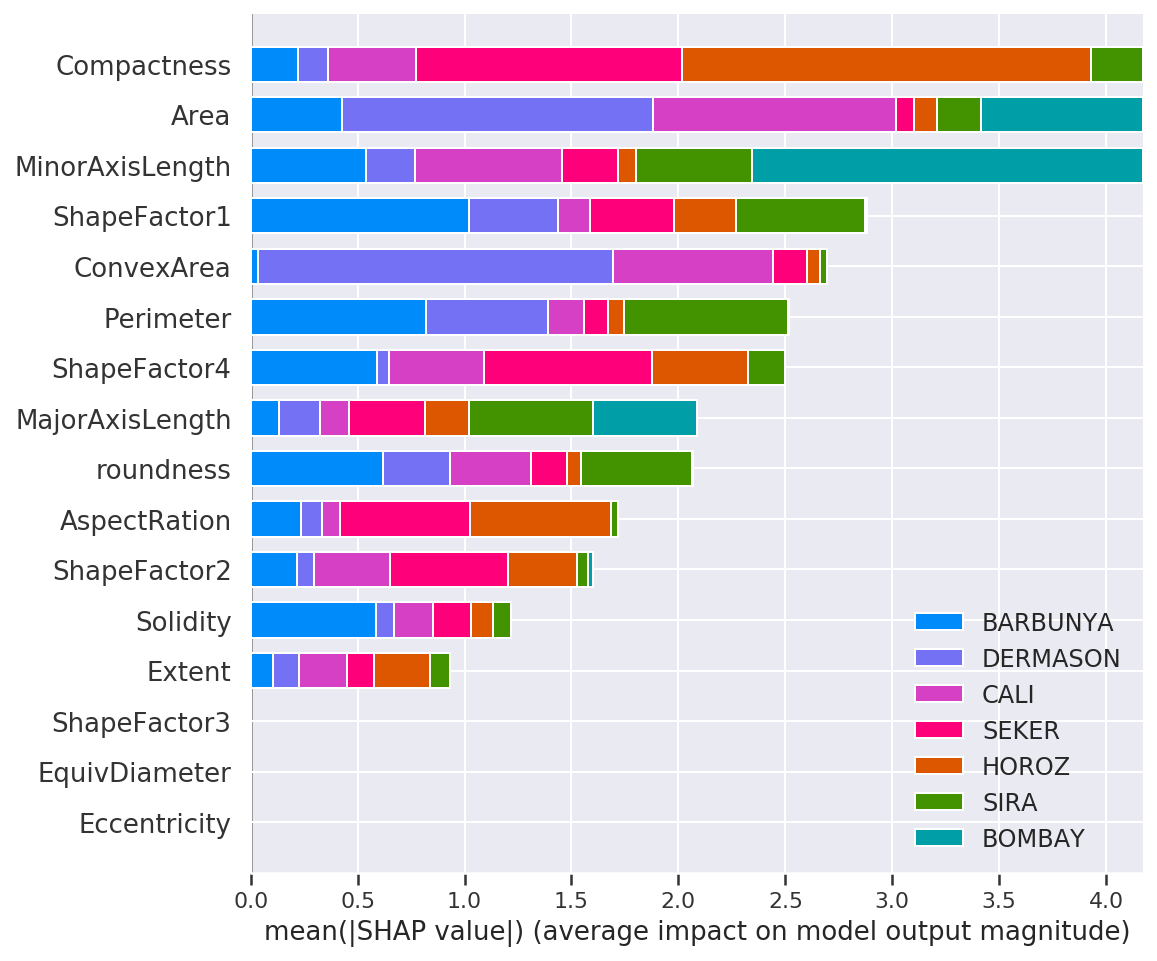

In [149]:
shap.summary_plot(shap_values, X_train_scaled.values, plot_type="bar",
                  class_names= class_names, feature_names = X_train_scaled.columns)

# 1번째 종, 'BARBUNYA' 콩의 SHAP summary_plot

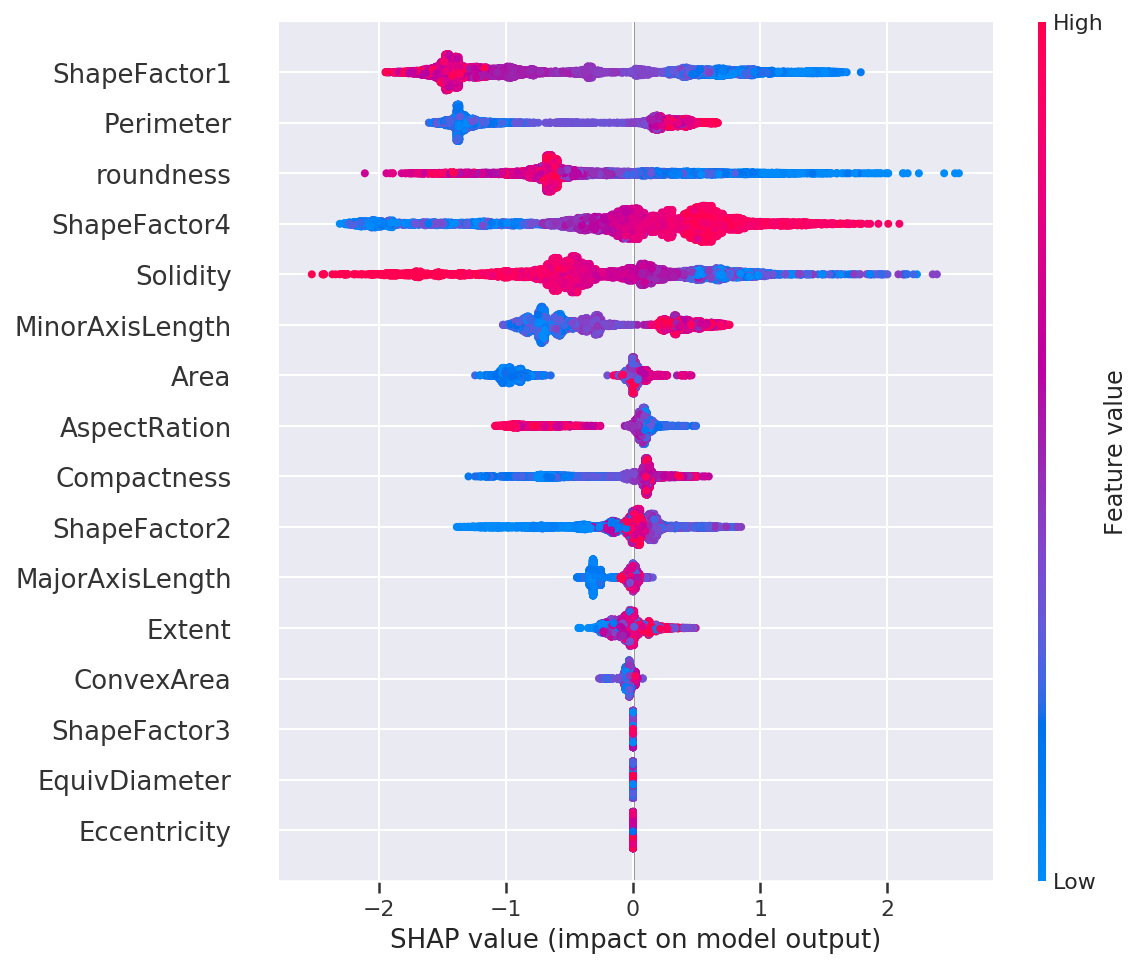

In [150]:
shap.summary_plot(shap_values[0], X_train_scaled.values, feature_names = X_train_scaled.columns)

# 2번째 종, 'BOMBAY' 콩의 SHAP summary_plot

# 그래프 형태가 확연히 다르다

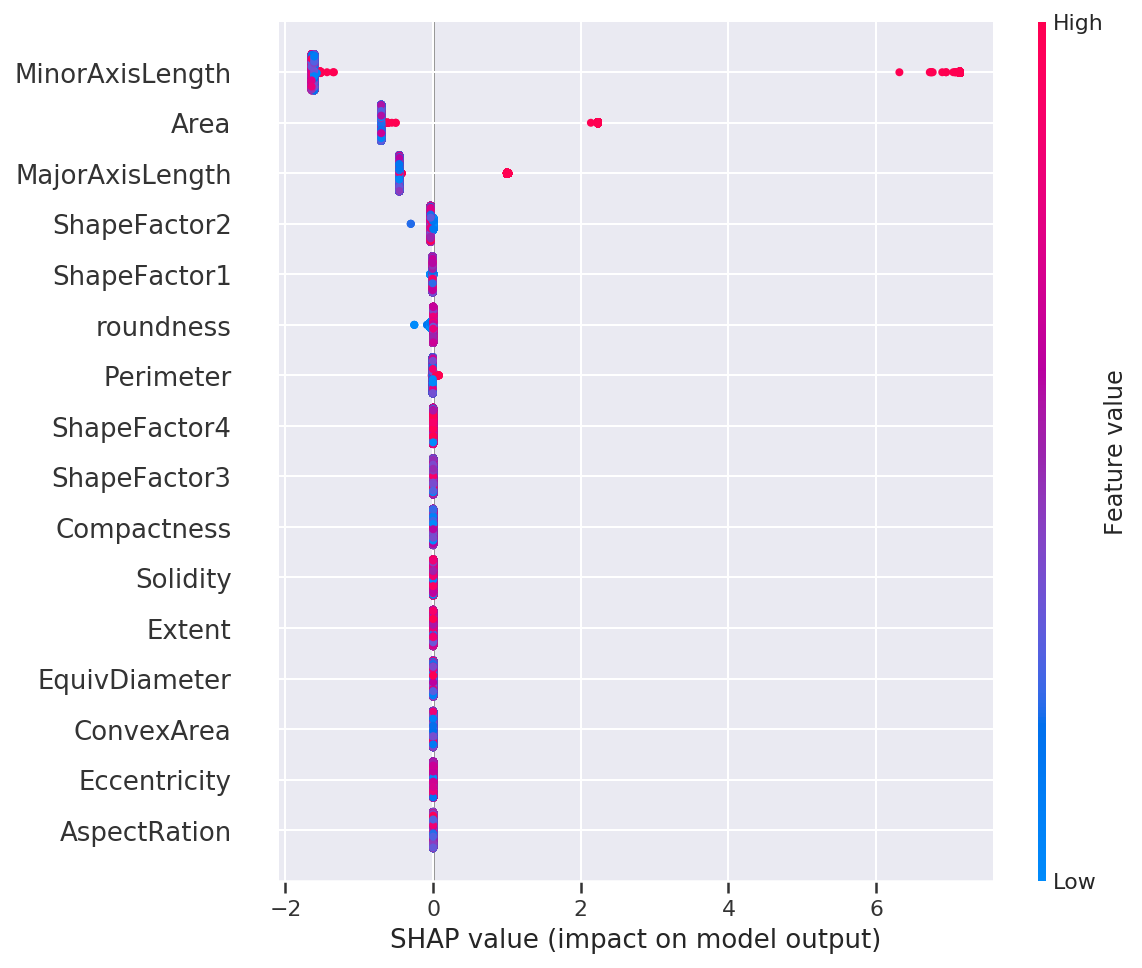

In [151]:
shap.summary_plot(shap_values[1], X_train_scaled.values, feature_names = X_train_scaled.columns)

# 3번째 종, 'CALI' 콩의 SHAP summary_plot

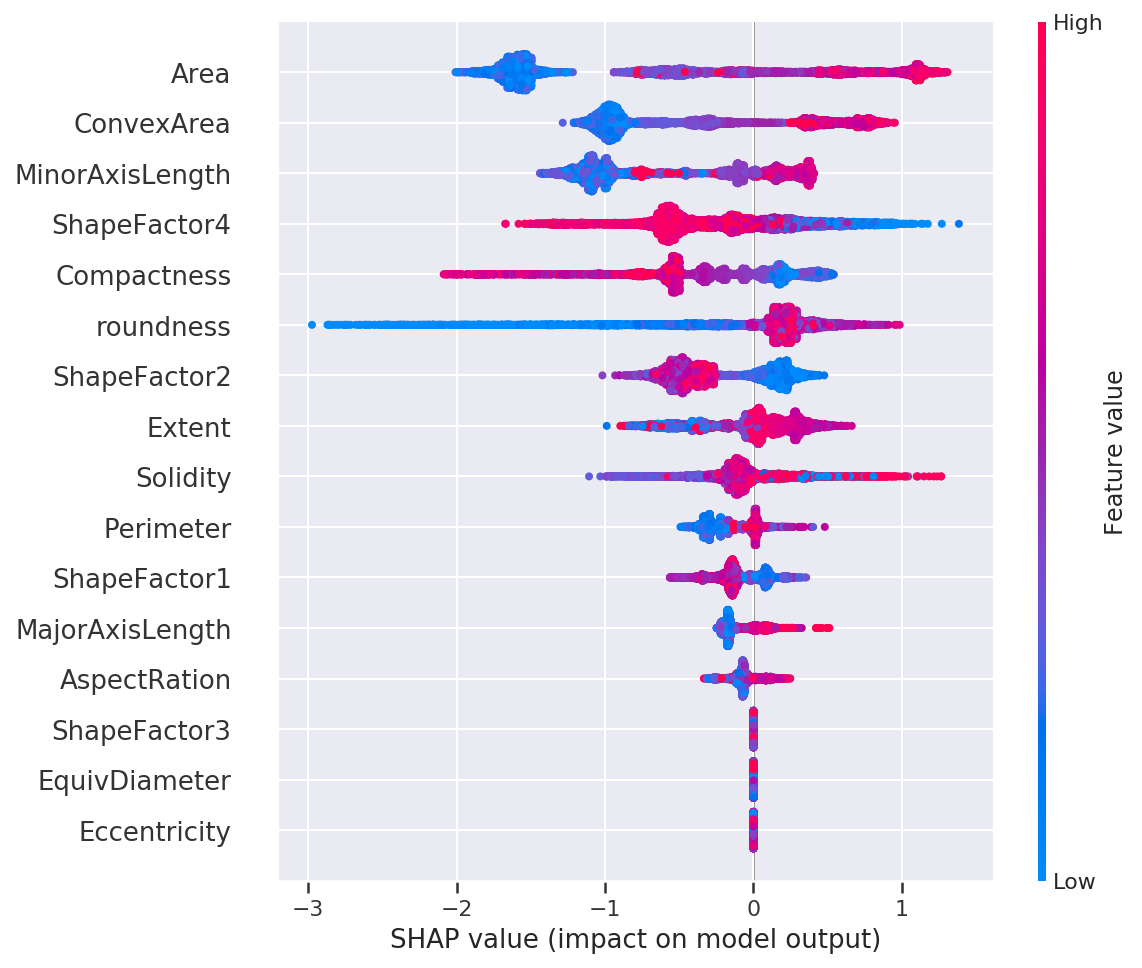

In [152]:
shap.summary_plot(shap_values[2], X_train_scaled.values, feature_names = X_train_scaled.columns)

# 1번째 종 'BARBUNYA' 중에서 첫번째 콩의 SHAP force_plot

In [153]:
shap.initjs()
i=0
shap.force_plot(explainer.expected_value[0], shap_values[0][i], X_train_scaled.values[i], feature_names = X_train_scaled.columns)

# 2번째 종 'BOMBAY' 중에서 첫번째 콩의 SHAP force_plot

In [178]:
shap.initjs()
i=0
shap.force_plot(explainer.expected_value[1], shap_values[1][i], X_train_scaled.values[i], feature_names = X_train_scaled.columns)

# 1번째 종 'BARBUNYA' 의 SHAP waterfall_plot

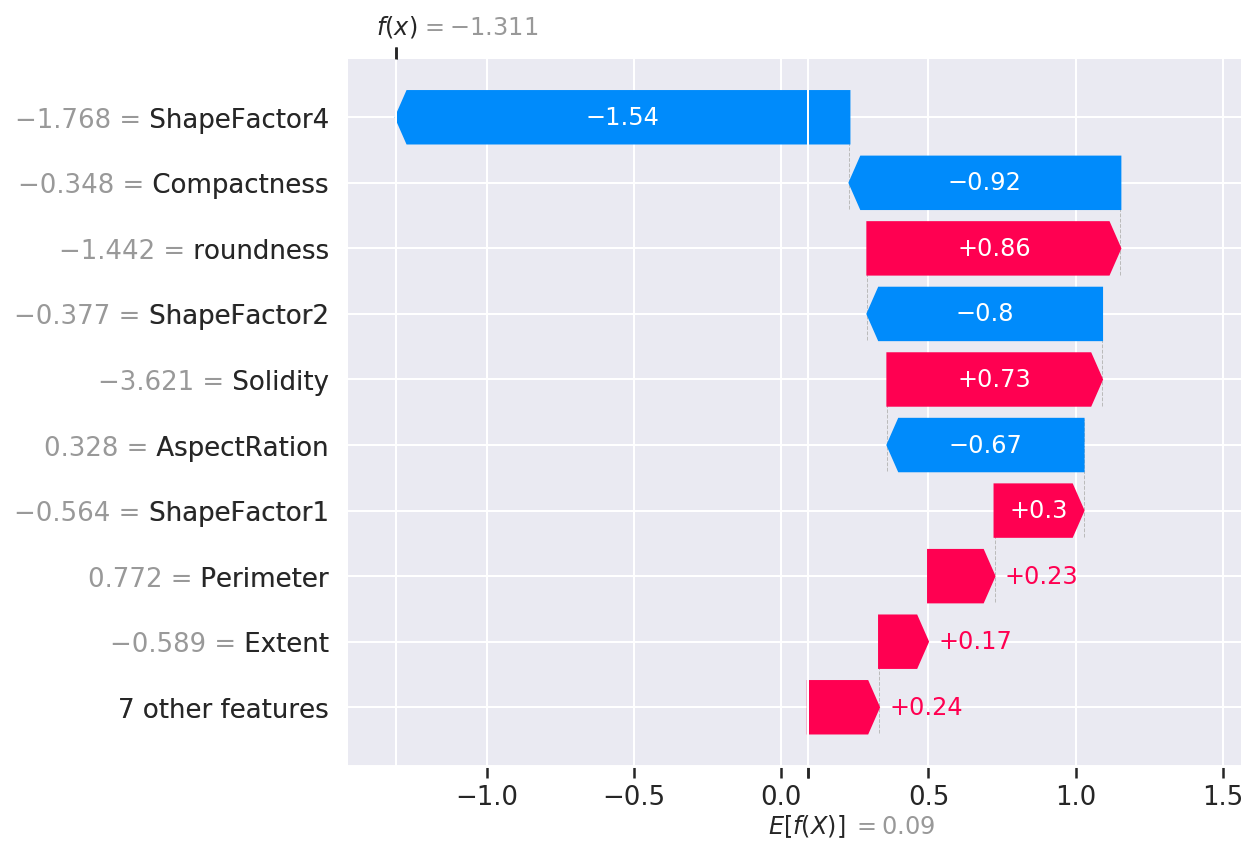

In [154]:
row = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
base_values=explainer.expected_value[0], data=X_test_scaled.iloc[row],  
feature_names=X_test.columns.tolist()))

# 12. LightGBM 모델
# XGBoost 모델의 버금가는 성능, 훨씬 빠른 학습 속도가 장점

In [155]:
lgbm_wrapper = LGBMClassifier(n_estimators=500)

evals = [(X_val_scaled, y_val)]
lgbm_wrapper.fit(X_train_scaled, y_train, early_stopping_rounds=30, eval_metric='logloss', eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_val_scaled)
pred_proba = lgbm_wrapper.predict_proba(X_val_scaled)[:,1]

[1]	valid_0's multi_logloss: 1.54009	valid_0's multi_logloss: 1.54009
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_logloss: 1.35007	valid_0's multi_logloss: 1.35007
[3]	valid_0's multi_logloss: 1.20253	valid_0's multi_logloss: 1.20253
[4]	valid_0's multi_logloss: 1.08333	valid_0's multi_logloss: 1.08333
[5]	valid_0's multi_logloss: 0.982695	valid_0's multi_logloss: 0.982695
[6]	valid_0's multi_logloss: 0.89701	valid_0's multi_logloss: 0.89701
[7]	valid_0's multi_logloss: 0.823699	valid_0's multi_logloss: 0.823699
[8]	valid_0's multi_logloss: 0.759501	valid_0's multi_logloss: 0.759501
[9]	valid_0's multi_logloss: 0.702979	valid_0's multi_logloss: 0.702979
[10]	valid_0's multi_logloss: 0.652911	valid_0's multi_logloss: 0.652911
[11]	valid_0's multi_logloss: 0.609211	valid_0's multi_logloss: 0.609211
[12]	valid_0's multi_logloss: 0.570076	valid_0's multi_logloss: 0.570076
[13]	valid_0's multi_logloss: 0.53498	valid_0's multi_logloss: 0.53498
[14]	valid

In [156]:
predict = lgbm_wrapper.predict(X_val_scaled)
f1=f1_score(y_val, predict, average='weighted')
print("F1 score: {}" .format(f1))
print()
print()
confusion = pd.DataFrame({'Class': val['Class'], 'Predict': predict})
# Create crosstab: ct
ct = pd.crosstab( confusion['Class'], confusion['Predict'])

print(classification_report(predict, val['Class']))
print()
ct

F1 score: 0.9204175312474705


              precision    recall  f1-score   support

    BARBUNYA       0.93      0.92      0.93       214
      BOMBAY       1.00      1.00      1.00        84
        CALI       0.94      0.95      0.94       258
    DERMASON       0.91      0.92      0.91       561
       HOROZ       0.94      0.96      0.95       292
       SEKER       0.93      0.93      0.93       321
        SIRA       0.88      0.85      0.86       437

    accuracy                           0.92      2167
   macro avg       0.93      0.93      0.93      2167
weighted avg       0.92      0.92      0.92      2167




Predict,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Class,,,,,,,
BARBUNYA,197,0,8,0,2,0,4
BOMBAY,0,84,0,0,0,0,0
CALI,9,0,245,0,5,1,1
DERMASON,0,0,0,516,0,14,37
HOROZ,2,0,5,3,281,0,7
SEKER,3,0,0,4,0,300,17
SIRA,3,0,0,38,4,6,371


# 튜닝을 하지 않았음에도 튜닝한 XGBoost 모델과 성능이 비슷하게 나온다

In [157]:
test_pred = lgbm_wrapper.predict(X_test_scaled)

confusion = pd.DataFrame({'Class': test['Class'], 'Predict': test_pred})
# Create crosstab: ct
ct = pd.crosstab(confusion['Class'], confusion['Predict'])

print(classification_report(test_pred, test['Class']))
print()
ct

              precision    recall  f1-score   support

    BARBUNYA       0.94      0.95      0.95       262
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.95      0.96      0.95       323
    DERMASON       0.91      0.92      0.92       705
       HOROZ       0.94      0.97      0.96       358
       SEKER       0.96      0.96      0.96       408
        SIRA       0.89      0.86      0.88       549

    accuracy                           0.93      2709
   macro avg       0.94      0.95      0.94      2709
weighted avg       0.93      0.93      0.93      2709




Predict,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Class,,,,,,,
BARBUNYA,250,0,8,0,0,2,5
BOMBAY,0,104,0,0,0,0,0
CALI,10,0,309,0,4,0,3
DERMASON,0,0,0,648,0,10,51
HOROZ,0,0,5,4,349,0,14
SEKER,2,0,0,9,0,390,5
SIRA,0,0,1,44,5,6,471


# LGBM 모델 하이퍼파라미터 튜닝
# 타겟을 숫자형으로 변환할 필요가 있다

In [158]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train) 
y_val_enc = le.fit_transform(y_val)
y_test_enc = le.fit_transform(y_test)

In [159]:
lgbm_clf = LGBMClassifier(n_estimators=500)

params = {'num_leaves': [32, 64],
          'max_depth':[128, 160],
          'min_child_samples':[60, 100],
          'sumsample':[0.8, 1]}

gridcv= GridSearchCV(lgbm_clf, param_grid=params, cv = 5)
gridcv.fit(X_train_scaled, y_train_enc, early_stopping_rounds=30, eval_metric='logloss', eval_set=[(X_train, y_train_enc),(X_val_scaled, y_val_enc)])

print()
print()
print('최적 파라미터:', gridcv.best_params_)


[1]	valid_0's multi_logloss: 1.89201	valid_0's multi_logloss: 1.89201	valid_1's multi_logloss: 1.55067	valid_1's multi_logloss: 1.55067
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_logloss: 1.95265	valid_0's multi_logloss: 1.95265	valid_1's multi_logloss: 1.36475	valid_1's multi_logloss: 1.36475
[3]	valid_0's multi_logloss: 2.00905	valid_0's multi_logloss: 2.00905	valid_1's multi_logloss: 1.21975	valid_1's multi_logloss: 1.21975
[4]	valid_0's multi_logloss: 2.04682	valid_0's multi_logloss: 2.04682	valid_1's multi_logloss: 1.10136	valid_1's multi_logloss: 1.10136
[5]	valid_0's multi_logloss: 2.08426	valid_0's multi_logloss: 2.08426	valid_1's multi_logloss: 1.0016	valid_1's multi_logloss: 1.0016
[6]	valid_0's multi_logloss: 2.13735	valid_0's multi_logloss: 2.13735	valid_1's multi_logloss: 0.916741	valid_1's multi_logloss: 0.916741
[7]	valid_0's multi_logloss: 2.18533	valid_0's multi_logloss: 2.18533	valid_1's multi_logloss: 0.842968	valid_1's multi_lo

In [160]:
m2 = gridcv.best_estimator_

m2.fit(X_val_scaled, y_val_enc)
print('테스트 정확도', m2.score(X_test_scaled, y_test_enc))
print()
predict = m2.predict(X_test_scaled)
f1=f1_score(y_test_enc, predict, average='weighted')
print()
print("F1 score: {}" .format(f1))

테스트 정확도 0.9224806201550387


F1 score: 0.9227475033564652


In [161]:
test_pred

array(['BARBUNYA', 'SIRA', 'HOROZ', ..., 'CALI', 'SIRA', 'BARBUNYA'],
      dtype=object)

In [162]:
y_test_enc

array([0, 6, 4, ..., 2, 6, 0])

# 튜닝 후 성능이 오히려 하락함
# 과적합 발생 가능성

In [163]:
test_pred = m2.predict(X_test_scaled)

confusion = pd.DataFrame({'Class': y_test_enc, 'Predict': test_pred})
# Create crosstab: ct
ct = pd.crosstab(confusion['Class'], confusion['Predict'])

print(classification_report(test_pred, y_test_enc))
print()
ct

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       262
           1       1.00      1.00      1.00       104
           2       0.93      0.94      0.94       324
           3       0.90      0.91      0.91       707
           4       0.95      0.96      0.95       366
           5       0.95      0.96      0.96       400
           6       0.88      0.85      0.87       546

    accuracy                           0.92      2709
   macro avg       0.94      0.94      0.94      2709
weighted avg       0.92      0.92      0.92      2709




Predict,0,1,2,3,4,5,6
Class,,,,,,,
0,247,0,10,0,0,1,7
1,0,104,0,0,0,0,0
2,12,0,304,0,7,0,3
3,0,0,0,641,0,8,60
4,0,0,9,4,352,0,7
5,1,0,0,17,0,385,3
6,2,0,1,45,7,6,466


## 13. 심층 신경망 모델 (DNN)

In [164]:
import tensorflow as tf
from tensorflow import keras

# 헬퍼(helper) 라이브러리를 임포트합니다
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.7.0


In [165]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

In [166]:
X_train_scaled.shape

(8667, 16)

In [167]:
len(y_train_enc)

8667

In [168]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# 모델 선언

In [169]:
def build_model():
  model = Sequential()
  model.add(Dense(128, activation='selu', kernel_initializer='lecun_normal', input_dim=16))
  model.add(Dense(64, activation='selu', kernel_initializer='lecun_normal'))
  model.add(Dense(32, activation='selu', kernel_initializer='lecun_normal'))
  model.add(Dense(7, activation='softmax'))

  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [170]:
model = build_model()

In [171]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

In [172]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# 학습

In [186]:
history = model.fit(X_train_scaled, y_train_enc, epochs=1000, batch_size=32, verbose=2, 
                    validation_data=(X_val_scaled, y_val_enc), callbacks=[early_stopping])


Epoch 1/1000
271/271 - 1s - loss: 0.1779 - accuracy: 0.9315 - val_loss: 0.2102 - val_accuracy: 0.9248 - 690ms/epoch - 3ms/step
Epoch 2/1000
271/271 - 1s - loss: 0.1784 - accuracy: 0.9350 - val_loss: 0.2011 - val_accuracy: 0.9271 - 601ms/epoch - 2ms/step
Epoch 3/1000
271/271 - 1s - loss: 0.1804 - accuracy: 0.9331 - val_loss: 0.2044 - val_accuracy: 0.9252 - 636ms/epoch - 2ms/step
Epoch 4/1000
271/271 - 1s - loss: 0.1752 - accuracy: 0.9348 - val_loss: 0.2179 - val_accuracy: 0.9211 - 545ms/epoch - 2ms/step
Epoch 5/1000
271/271 - 1s - loss: 0.1768 - accuracy: 0.9347 - val_loss: 0.2009 - val_accuracy: 0.9275 - 561ms/epoch - 2ms/step
Epoch 6/1000
271/271 - 1s - loss: 0.1757 - accuracy: 0.9342 - val_loss: 0.2008 - val_accuracy: 0.9280 - 569ms/epoch - 2ms/step
Epoch 7/1000
271/271 - 1s - loss: 0.1759 - accuracy: 0.9333 - val_loss: 0.2053 - val_accuracy: 0.9243 - 639ms/epoch - 2ms/step
Epoch 8/1000
271/271 - 1s - loss: 0.1690 - accuracy: 0.9369 - val_loss: 0.2089 - val_accuracy: 0.9234 - 617ms/e

In [187]:
model.evaluate(X_val_scaled, y_val_enc)

68/68 [==============================] - 0s 1ms/step - loss: 0.2012 - accuracy: 0.9285


[0.2011599987745285, 0.9284725189208984]

In [189]:
model.evaluate(X_test_scaled, y_test_enc)

85/85 [==============================] - 0s 2ms/step - loss: 0.1660 - accuracy: 0.9369


[0.16597802937030792, 0.9368770718574524]

# 모델이 생성한 값을 바탕으로 판단 가능한 클래스로 변환

In [191]:
y_pred_proba = model.predict(X_test_scaled)
y_pred_proba[:10]

array([[9.9808300e-01, 1.7215751e-11, 5.9818989e-04, 2.5994813e-09,
        1.2579333e-03, 3.6877089e-05, 2.3928349e-05],
       [1.2656506e-03, 1.4994507e-09, 3.1221902e-05, 6.8745750e-04,
        9.8175090e-04, 7.9392776e-05, 9.9695456e-01],
       [8.1006085e-08, 1.0242053e-09, 1.2252897e-07, 7.3571621e-10,
        9.9999380e-01, 3.0669816e-09, 6.0196262e-06],
       [4.8908087e-06, 2.5586530e-06, 1.5768735e-05, 9.6788681e-01,
        7.0168934e-04, 7.1461377e-04, 3.0673679e-02],
       [1.1160511e-04, 7.8360767e-09, 9.9980193e-01, 1.1385046e-14,
        7.9097546e-05, 7.4454970e-06, 5.3600751e-08],
       [5.5603061e-05, 9.6821259e-07, 3.6972604e-04, 9.7424895e-01,
        1.2203351e-03, 5.9018112e-03, 1.8202554e-02],
       [3.5999037e-08, 8.0691706e-07, 2.2135688e-07, 2.0832508e-07,
        9.9998724e-01, 2.5353508e-09, 1.1490561e-05],
       [5.0582702e-08, 1.5282152e-06, 9.1451915e-07, 9.9993491e-01,
        1.9447336e-05, 7.2383000e-07, 4.2472268e-05],
       [1.2753118e-05, 3

# 각 개체마다 7개의 수 중 가장 큰 값이 예측한 클래스 값
# softmax

In [192]:
y_pred_label = np.argmax(y_pred_proba, axis=-1)
y_pred_label[:10]

array([0, 6, 4, 3, 2, 3, 4, 3, 3, 5])

In [182]:
y_test_enc[:10]

array([0, 6, 4, 3, 2, 3, 4, 3, 3, 5])

# 신경망 모델이 성능이 가장 우수하다.
# accuracy: 94%,  f1_score: 94%

In [193]:
f1=f1_score(y_test_enc, y_pred_label, average='weighted')
print("F1 score: {}" .format(f1))

# confusion = pd.DataFrame({'Class': ['Class'], 'Predict': predict})
# # Create crosstab: ct
# ct = pd.crosstab(confusion['Predict'], confusion['Class'])
print()
print(classification_report(y_pred_label, y_test_enc))


F1 score: 0.9370860644734252

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       268
           1       1.00      1.00      1.00       104
           2       0.95      0.97      0.96       322
           3       0.92      0.92      0.92       714
           4       0.93      0.97      0.95       354
           5       0.97      0.97      0.97       405
           6       0.90      0.87      0.88       542

    accuracy                           0.94      2709
   macro avg       0.95      0.95      0.95      2709
weighted avg       0.94      0.94      0.94      2709



In [194]:
confusion = pd.DataFrame({'Class': y_test_enc, 'Predict': y_pred_label})
# Create crosstab: ct
ct = pd.crosstab(confusion['Predict'], confusion['Class'])
ct

Class,0,1,2,3,4,5,6
Predict,,,,,,,
0,258,0,7,0,0,2,1
1,0,104,0,0,0,0,0
2,4,0,311,0,6,0,1
3,0,0,0,655,5,10,44
4,0,0,5,0,345,0,4
5,0,0,0,8,1,392,4
6,3,0,3,46,15,2,473


# 신경망 모델의 학습 손실함수 곡선과 정확도 곡선

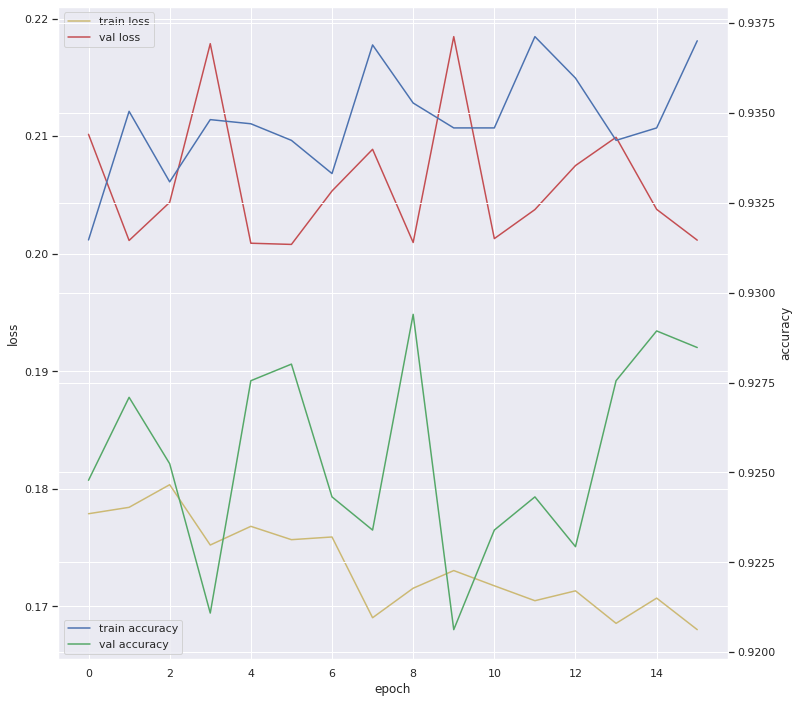

In [195]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(12,12))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label = 'train loss')
loss_ax.plot(history.history['val_loss'], 'r', label = 'val loss')

acc_ax.plot(history.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label = 'val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()

In [ ]:
'''
pipe = make_pipeline(
    RobustScaler(),
    DecisionTreeClassifier(random_state=42)
)

params = {
    'decisiontreeclassifier__class_weight' : [None],
    'decisiontreeclassifier__max_depth' : [16],
    'decisiontreeclassifier__min_samples_leaf' : [5,6,7],
    #'decisiontreeclassifier__min_samples_split' : [2,3,4,5,6],
    'decisiontreeclassifier__max_features':[12]
}

clf1 = GridSearchCV(
    pipe,
    param_grid=params,
    cv=5,
    n_jobs=-1
    )

clf1.fit(X_train, y_train)


print('최적 하이퍼파라미터: ', clf1.best_params_)
print('accuracy: ', clf1.best_score_)

m1 = clf1.best_estimator_

m1.fit(X_val, y_val)
print('검증 정확도', m1.score(X_val, y_val))

predict = m1.predict(X_val)
f1=f1_score(y_val, predict, average='weighted')

print("F1 score: {}" .format(f1))



pipe = make_pipeline(
    RobustScaler(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

params = {
    'randomforestclassifier__class_weight' : [None],
    'randomforestclassifier__max_depth' : [14,15,16,17,18],
    'randomforestclassifier__n_estimators' : [450,500,550],
    'randomforestclassifier__min_samples_leaf' : [2,3,4,5,6],
    'randomforestclassifier__max_features' : ['auto']
}

clf1 = GridSearchCV(
    pipe,
    param_grid=params,
    cv=5,
    n_jobs=-1
    )

clf1.fit(X_train, y_train)


print('최적 하이퍼파라미터: ', clf1.best_params_)
print('accuracy: ', clf1.best_score_)

m1 = clf1.best_estimator_

m1.fit(X_val, y_val)
print('검증 정확도', m1.score(X_val, y_val))

predict = m1.predict(X_val)
f1=f1_score(y_val, predict, average='weighted')

print("F1 score: {}" .format(f1))

pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)

pipe.fit(X_train, y_train);


print('최적 하이퍼파라미터: ', clf1.best_params_)
print('accuracy: ', clf1.best_score_)

m1 = clf1.best_estimator_

m1.fit(X_val, y_val)
print('검증 정확도', m1.score(X_val, y_val))

predict = m1.predict(X_val)
f1=f1_score(y_val, predict, average='weighted')

print("F1 score: {}" .format(f1))

from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight('balanced', y_train)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

model = LGBMClassifier(
    n_estimators=1000,
    max_depth=16,
    min_child_samples=20,
    num_leaves=144,
    learning_rate=0.2,
    scale_pos_weight=classes_weights,
    early_stopping_rounds=30,

    n_jobs=-1
)

eval_set = [(X_train_scaled, y_train),
            (X_val_scaled, y_val)]

model.fit(X_train_scaled, y_train,
          eval_set=eval_set,
          eval_metric='mlogloss',
          early_stopping_rounds=30
         )

params = {'learning_rate': 0.01,
          'max_depth': 16,
          'boosting': 'gbdt',
          'objective': 'classification',
          'metric': 'auc',
          'is_training_metric': True,
          'num_leaves': 144,
          'feature_fraction': 0.9,
          'bagging_fraction': 0.7,
          'bagging_freq': 5,
          'scale_pos_weight': classes_weights,
          'seed':2021}

import lightgbm as lgb

train_ds = lgb.Dataset(X_train_scaled, label = y_train)
test_ds = lgb.Dataset(X_val_scaled, label = y_val)

model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)

predict_train = model.predict(X_train_scaled)
predict_val = model.predict(X_val_scaled)
'''